https://mne.tools/stable/auto_tutorials/forward/35_eeg_no_mri.html



# EEG forward operator with a template MRI

This tutorial explains how to compute the forward operator from EEG data
using the standard template MRI subject ``fsaverage``.

.. caution:: Source reconstruction without an individual T1 MRI from the
             subject will be less accurate. Do not over interpret activity
             locations which can be off by multiple centimeters.

## Adult template MRI (fsaverage)
First we show how ``fsaverage`` can be used as a surrogate subject.


In [ ]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Joan Massich <mailsik@gmail.com>
#          Eric Larson <larson.eric.d@gmail.com>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

import numpy as np

import mne
from mne.datasets import eegbci, fetch_fsaverage

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = fs_dir.parent

# The files live in:
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src = fs_dir / "bem" / "fsaverage-ico-5-src.fif"
bem = fs_dir / "bem" / "fsaverage-5120-5120-5120-bem-sol.fif"

### Load the data

We use here EEG data from the BCI dataset.

<div class="alert alert-info"><h4>Note</h4><p>See `plot_montage` to view all the standard EEG montages
          available in MNE-Python.</p></div>



In [ ]:
(raw_fname,) = eegbci.load_data(subjects=1, runs=[6])
raw = mne.io.read_raw_edf(raw_fname, preload=True)

# Clean channel names to be able to use a standard 1005 montage
eegbci.standardize(raw)

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)  # needed for inverse modeling

# Check that the locations of EEG electrodes is correct with respect to MRI
mne.viz.plot_alignment(
    raw.info,
    src=src,
    eeg=["original", "projected"],
    trans=trans,
    show_axes=True,
    mri_fiducials=True,
    dig="fiducials",
)

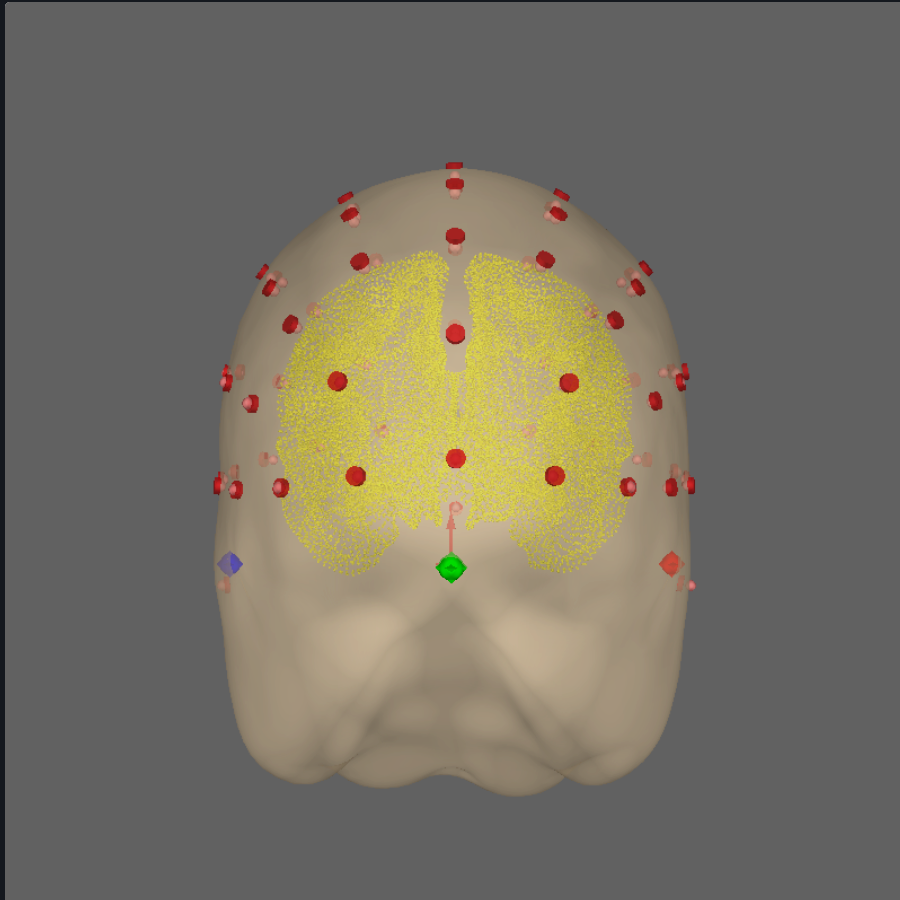

### Setup source space and compute forward



In [ ]:
fwd = mne.make_forward_solution(
    raw.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None
)
fwd

From here on, standard inverse imaging methods can be used!

## Infant MRI surrogates
We don't have a sample infant dataset for MNE, so let's fake a 10-20 one:



In [ ]:
ch_names = "Fz Cz Pz Oz Fp1 Fp2 F3 F4 F7 F8 C3 C4 T7 T8 P3 P4 P7 P8 O1 O2".split()
data = np.random.RandomState(0).randn(len(ch_names), 1000)
info = mne.create_info(ch_names, 1000.0, "eeg")
raw = mne.io.RawArray(data, info)

### Get an infant MRI template
To use an infant head model for M/EEG data, you can use
:func:`mne.datasets.fetch_infant_template` to download an infant template:



In [ ]:
subject = mne.datasets.fetch_infant_template("6mo", subjects_dir, verbose=True)

It comes with several helpful built-in files, including a 10-20 montage
in the MRI coordinate frame, which can be used to compute the
MRI<->head transform ``trans``:



In [ ]:
fname_1020 = subjects_dir / subject / "montages" / "10-20-montage.fif"
mon = mne.channels.read_dig_fif(fname_1020, verbose="error")  # should be named -dig.fif
mon.rename_channels({f"EEG{ii:03d}": ch_name for ii, ch_name in enumerate(ch_names, 1)})
trans = mne.channels.compute_native_head_t(mon)
raw.set_montage(mon)
print(trans)

There are also BEM and source spaces:



In [ ]:
bem_dir = subjects_dir / subject / "bem"
fname_src = bem_dir / f"{subject}-oct-6-src.fif"
src = mne.read_source_spaces(fname_src)
print(src)
fname_bem = bem_dir / f"{subject}-5120-5120-5120-bem-sol.fif"
bem = mne.read_bem_solution(fname_bem)

You can ensure everything is as expected by plotting the result:



In [ ]:
fig = mne.viz.plot_alignment(
    raw.info,
    subject=subject,
    subjects_dir=subjects_dir,
    trans=trans,
    src=src,
    bem=bem,
    coord_frame="mri",
    mri_fiducials=True,
    show_axes=True,
    surfaces=("white", "outer_skin", "inner_skull", "outer_skull"),
)
mne.viz.set_3d_view(fig, 25, 70, focalpoint=[0, -0.005, 0.01])

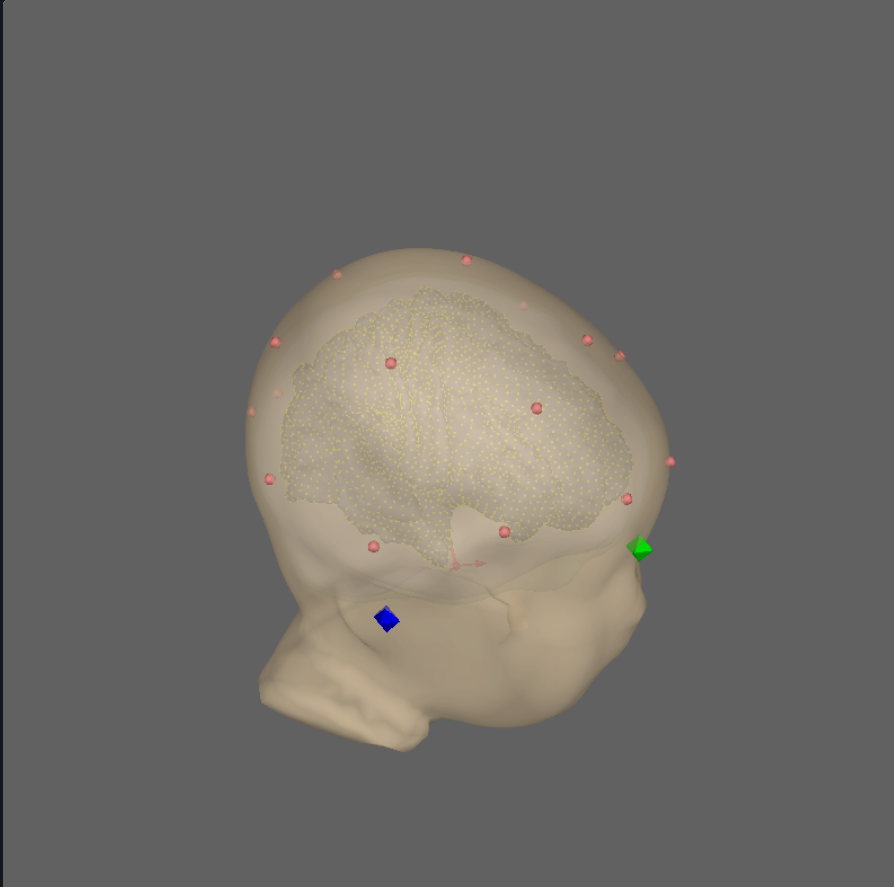

From here, standard forward and inverse operators can be computed

If you have digitized head positions or MEG data, consider using
`mne coreg` to warp a suitable infant template MRI to your
digitization information.

